In [1]:
import sys
import os

# Adjust the path to point to your project root.
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
from modules import Bloch, Model, K_mesh, Wannier
from modules.bloch import finite_diff_coeffs, levi_civita
from modules.axion import get_axion_angle
from example.models import fu_kane_mele
# from pythtb import *
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial
from itertools import product

%load_ext line_profiler
%timeit

In [3]:
########## Model #############

# Reference Model
t = 1     # spin-independent first-neighbor hop
soc = 1/4   # spin-dependent second-neighbor hop
m = 1/2     # magnetic field magnitude
beta = np.pi/4  # Adiabatic parameter
fkm_model = fu_kane_mele(t, soc, m, beta)

# Model generator for a set of fixed parameters
fixed_params = {"t": 1.0, "soc": 1/4, "m": 1/2}
model_gen = partial(fu_kane_mele, **fixed_params)

### Adiabatic parameters
# k space
nks = 40, 40, 40
k_flat = np.array(list(product(*[np.linspace(0, 1, nk, endpoint=False) for nk in nks])))

# lambda space
n_beta = 120
max_beta = 2*np.pi
betas = np.linspace(0, max_beta, n_beta, endpoint=False) # change to endpoint=False for periodic
lambda_vals = {"beta": betas}

########### Useful model information ###########
recip_lat_vecs = fkm_model.get_recip_lat_vecs()  # Reciprocal lattice vectors (Cartesian)
n_spin = fkm_model.n_spin   # Number of spins
n_orb = fkm_model.n_orb     # Number of orbitals
n_states = n_spin * n_orb   # Total number of states
n_occ = n_states//2         # Number of occupied states

n_param = nks + (n_beta,)    # Number of points in 4d mesh
dim_k = fkm_model.dim_k      # Number of k-space dimensions (3)
dim_lam = 1                  # Number of adiabatic dimensions (1)
dim_total = dim_k + dim_lam  # Total number of dimensions (4)

print(f"Number of orbs: {n_spin}")
print(f"Number of spins: {n_spin}")
print("Number of states:", n_states)
print("Number of occupied bands:", n_occ)
print("(nks, nbeta):", n_param)
print("Total number of parameter points:", np.prod(n_param))


Number of orbs: 2
Number of spins: 2
Number of states: 4
Number of occupied bands: 2
(nks, nbeta): (40, 40, 40, 120)
Total number of parameter points: 7680000


In [4]:
thetas_c2 = np.load('data/thetas_kubo_40_40_40_120.npy')

Text(0.5, 1.0, 'number of parameters: (40, 40, 40, 120)')

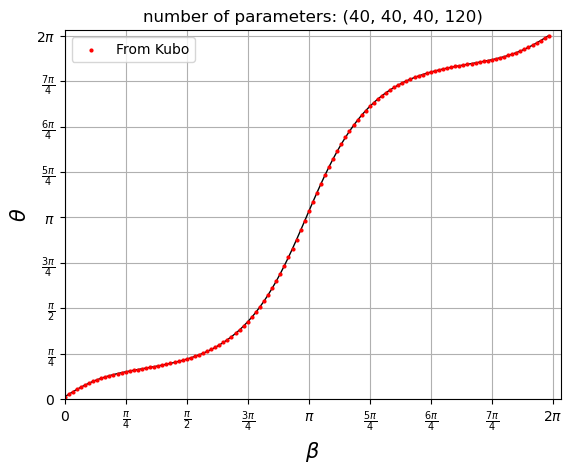

In [5]:
#### Plotting theta(beta)

fig, ax = plt.subplots()

### Riemann sum
ax.plot(betas, thetas_c2.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas_c2.real, s=4, zorder=2, c='r', label='From Kubo')

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

ax.set_ylim(0, 2*np.pi+0.1)
ax.set_xlim(0, 2*np.pi+0.1) 

# ax.set_ylim(np.pi-0.5, np.pi+0.5)
# ax.set_xlim(np.pi-0.1, np.pi+0.1) 

ax.grid()
ax.legend()
ax.set_title(f"number of parameters: {n_param}")

In [6]:
def flat_spin_H(model, H_k):
    # flatten spin axes
    if H_k.ndim == 2 * model._nspin + 1:
        # have k points
        new_shape = (H_k.shape[0],) + (
            model._nspin * model._norb,
            model._nspin * model._norb,
        )
    elif H_k.ndim == 2 * model._nspin:
        # must be a finite sample, no k-points
        new_shape = (model._nspin * model._norb, model._nspin * model._norb)
    else:
        raise ValueError("Hamiltonian has wrong shape.")

    ham_use = H_k.reshape(*new_shape)

    if not np.allclose(ham_use, ham_use.swapaxes(-1, -2).conj()):
        raise Exception("Hamiltonian matrix is not hermitian")
    
    return ham_use

def get_evec_shape(model, H_k):
     if H_k.ndim == 2 * model._nspin + 1:
        if model._nspin == 1:
            shape_evecs = (H_k.shape[0],) + (model._norb, model._norb)
        elif model._nspin == 2:
            shape_evecs = (H_k.shape[0],) + (
                model._nspin * model._norb,
                model._norb,
                model._nspin,
            )
        elif H_k.ndim == 2 * model._nspin:
            if model._nspin == 1:
                shape_evecs = (model._norb, model._norb)
            elif model._nspin == 2:
                shape_evecs = (model._nspin * model._norb, model._norb, model._nspin)
        else:
            raise ValueError("Hamiltonian has wrong shape.")
        return shape_evecs
     
def fin_diff(U_k, mu, dk_mu, order_eps, mode='central'):
    coeffs, stencil = finite_diff_coeffs(order_eps=order_eps, mode=mode)

    fd_sum = np.zeros_like(U_k)

    for s, c in zip(stencil, coeffs):
        fd_sum += c * np.roll(U_k, shift=-s, axis=mu)

    v = fd_sum / (dk_mu)
    return v

In [7]:
betas_kc = np.linspace(0, 2*np.pi, 21, endpoint=True)
nks = 50, 50, 50
thetas_kc = np.zeros((betas_kc.shape[0]))

for idx, beta in enumerate(betas_kc):
    model = fu_kane_mele(t, soc, m, beta)

    # trial wavefunctions of form (orbital, spin, amp)
    if beta == np.pi:
        tf_list = [ 
            [(0, 0, -1), (0, 1, 1)], 
            [(1, 0, 1), (1, 1, 1)]
            ]
    else:
        tf_list = [ [(0, 0, 1), (1, 0, -1)], [(0, 1, 1), (1, 1, -1)]]

    theta = get_axion_angle(model, tf_list, *nks)
    print(f"idx: {idx}, beta: {beta}, theta: {theta.real}")

2025-04-22 16:37:26.839437: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-22 16:37:26.839467: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-04-22 16:37:26.839475: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-04-22 16:37:26.839491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-22 16:37:26.839500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


idx: 0, beta: 0.0, theta: -9.837165752350621e-10
idx: 1, beta: 0.3141592653589793, theta: 0.24201775331941214
idx: 2, beta: 0.6283185307179586, theta: 0.39660980086026165
idx: 3, beta: 0.9424777960769379, theta: 0.48734399961969915
idx: 4, beta: 1.2566370614359172, theta: 0.563328831486623
idx: 5, beta: 1.5707963267948966, theta: 0.6628194241072461
idx: 6, beta: 1.8849555921538759, theta: 0.8220063589151194
idx: 7, beta: 2.199114857512855, theta: 1.088173874186812
idx: 8, beta: 2.5132741228718345, theta: 1.5284752817194096
idx: 9, beta: 2.827433388230814, theta: 2.2264216410828186
idx: 10, beta: 3.141592653589793, theta: 3.1415935148372296
idx: 11, beta: 3.4557519189487724, theta: -2.226421698273306
idx: 12, beta: 3.7699111843077517, theta: -1.528475303605569
idx: 13, beta: 4.084070449666731, theta: -1.0881738696871057
idx: 14, beta: 4.39822971502571, theta: -0.8220063719890102
idx: 15, beta: 4.71238898038469, theta: -0.6628194044062116
idx: 16, beta: 5.026548245743669, theta: -0.56332

In [ ]:
betas_kc = np.linspace(0, 2*np.pi, 21, endpoint=True)
nks = 50, 50, 50
thetas_kc = np.zeros((betas_kc.shape[0]))

for idx, beta in enumerate(betas_kc):
    model = fu_kane_mele(t, soc, m, beta)
    bloch_states = Bloch(model, *nks)
    bloch_states.set_Bloch_ham()
    
    # Bloch Hamiltonian, reshape and get eigenvector shapes
    H_k = bloch_states.H_k
    H_k = H_k.reshape(-1, n_orb, n_spin, n_orb, n_spin)
    shape_evecs = get_evec_shape(model, H_k)
    H_k = flat_spin_H(model, H_k)

    # k-mesh flat and square
    flat_mesh = bloch_states.k_mesh.flat_mesh

    H_tf = tf.convert_to_tensor(H_k, dtype=tf.complex64)
    eval, evec = tf.linalg.eigh(H_tf)  # runs on METAL if plugin is installed
    eval = eval.numpy()
    evec = evec.numpy()
     
    evec = evec.swapaxes(-1, -2)
    evec = evec.reshape(*shape_evecs)
    
    # Make k-axes square instead of flat
    eigvecs = evec.reshape(*bloch_states.k_mesh.nks, *evec.shape[1:])
    eigvals = eval.reshape(*bloch_states.k_mesh.nks, *eval.shape[1:])

    # Set bloch states energies, wfs, and set energy eigenstate flag to True
    bloch_states.energies = eigvals
    bloch_states.set_wfs(eigvecs, spin_flattened=False, set_projectors=False)
    bloch_states.is_energy_eigstate = True

    # velocity operator
    v_k = model.get_velocity(flat_mesh)
    # axes for each k-dimension, flatten spin
    v_k = v_k.reshape(model.dim_r, *nks, model.n_spin * model.n_orb, model.n_spin * model.n_orb)

    # Energy eigensates (flattened spin and unflattened)
    u_nk = bloch_states.get_states()["Cell periodic"]
    u_nk_flat = bloch_states.get_states(flatten_spin=True)["Cell periodic"]
    E_nk = bloch_states.energies

    # Getting occupied and conduction states and energies
    n_occ = bloch_states._n_states//2
    u_occ = u_nk[..., :n_occ, :, :]
    u_con = u_nk[..., n_occ:, :, :]

    # Bloch class for occupied bands
    bloch_occ = Bloch(model, *nks)
    bloch_occ.set_wfs(u_occ, cell_periodic=True, set_projectors=False)
    # Bloch class for conduction bands
    bloch_con = Bloch(model, *nks)
    bloch_con.set_wfs(u_con, cell_periodic=True, set_projectors=False)

    # Getting spin flattened occupied and conduction states and energies
    psi_occ_flat = bloch_occ.get_states(flatten_spin=True)["Bloch"]
    psi_con_flat = bloch_con.get_states(flatten_spin=True)["Bloch"]

    ### Projection
    # Just for getting trial wavefunctions
    WF = Wannier(model, bloch_states, *nks)

    # For tilde (projection) gauge states
    bloch_tilde = WF.tilde_states

    # trial wavefunctions of form (orbital, spin, amp)
    tf_list = [ [(0, 0, 1), (1, 0, -1)], [(0, 1, 1), (1, 1, -1)]]

    if beta == np.pi:
        # tf_list = [ 
        #     [(0, 0, 1), (0, 1, 1)], 
        #     [(1, 0, 1), (1, 1, -1)]
        #     ]
         tf_list = [ 
             [(0, 0, -1), (0, 1, 1)], 
             [(1, 0, 1), (1, 1, 1)]
             ]

    twfs = WF.get_trial_wfs(tf_list)
    # Flatten spin axis
    twfs_flat = twfs.reshape((*twfs.shape[:1], -1))

    # Overlap matrix S_nm = <psi_nk| g_m> with occupied bands
    S_occ = np.einsum("...nj, mj -> ...nm", psi_occ_flat.conj(), twfs_flat)
    # Overlap matrix S_nm = <psi_nk| g_m> with conduction bands
    S_con = np.einsum("...nj, mj -> ...nm", psi_con_flat.conj(), twfs_flat)

    S_tf = tf.convert_to_tensor(S_occ, dtype=tf.complex64)

    # batched SVD on Metal
    D, W, V = tf.linalg.svd(S_tf, full_matrices=True)

    # back to NumPy for the rest
    W, D, V = W.numpy(), D.numpy(), V.numpy()

    D_mat = np.einsum("...i, ij -> ...ij", D, np.eye(D.shape[-1])) # Make a diagonal matrix
    Vh = V.conj().swapaxes(-1,-2)
    # Unitary part
    U_SVD = W @ Vh
    # Semi-positive definite Hermitian part
    P = V @ D_mat @ Vh
       
    # Use unitary to rotate occupied bands into tilde basis for smooth gauge
    psi_tilde = np.einsum("...mn, ...mj -> ...nj", U_SVD, psi_occ_flat) # shape: (*nks, states, orbs*n_spin])
    # set wfs in Bloch class
    bloch_tilde.set_wfs(psi_tilde, cell_periodic=False, spin_flattened=True, set_projectors=False)

    occ_idxs = np.arange(2)
    cond_idxs = np.setdiff1d(np.arange(u_nk_flat.shape[-2]), occ_idxs)  # Identify conduction bands

    # Velocity operator in energy eigenbasis
    evecs_conj_tf = u_nk_flat.conj()
    evecs_T_tf = u_nk_flat.swapaxes(-1,-2)  # (n_kpts, n_beta, n_state, n_state)

    v_k_rot = np.matmul(
            evecs_conj_tf[None, ...],  # (1, n_kpts, n_state, n_state)
            np.matmul(
                v_k,                       # (dim_k, n_kpts, n_state, n_state)
                evecs_T_tf[None, ...]  # (1, n_kpts, n_beta, n_state, n_state)
            )
        ) 
    
    # Compute energy denominators
    delta_E = E_nk[..., None, :] - E_nk[..., :, None]
    delta_E_occ_cond = np.take(np.take(delta_E, occ_idxs, axis=-2), cond_idxs, axis=-1)
    inv_delta_E_occ_cond_tf = 1 / delta_E_occ_cond

    v_occ_cond = np.take(np.take(v_k_rot, occ_idxs, axis=-2), cond_idxs, axis=-1)
    v_cond_occ = np.take(np.take(v_k_rot, cond_idxs, axis=-2), occ_idxs, axis=-1)
    v_occ_cond = v_occ_cond * -inv_delta_E_occ_cond_tf
    v_cond_occ = v_cond_occ * -inv_delta_E_occ_cond_tf

    # vhat
    vhat = v_occ_cond 

    # NOTE: This term was not included in 1D derivation with orbitals at origin
    orb_vecs = model.get_orb_vecs(Cartesian=False)
    r_mu_twfs = 2*np.pi * (orb_vecs.T[:, None, :, None] * twfs).reshape(3, 2, 4)
    # rhat
    rhat = np.einsum("...nj, amj -> a...nm", psi_occ_flat.conj(), r_mu_twfs)

    term =  S_occ.conj().swapaxes(-1,-2) @ (rhat + 1j*vhat@ S_con)
    term = Vh @ term @ Vh.conj().swapaxes(-1,-2)

    for a in range(term.shape[-2]):
        for b in range(term.shape[-1]):
            term[..., a, b] *= (1 / (D[..., a] + D[..., b]))

    term = Vh.conj().swapaxes(-1,-2) @ term @ Vh
    term  = term - term.conj().swapaxes(-1,-2)

    # Berry connection in projection gauge
    A_til = (
        U_SVD.conj().swapaxes(-1,-2) @ (rhat + 1j*vhat @ S_con)
        - term
    ) @ np.linalg.inv(P) 

    omega_kubo = bloch_states.berry_curv(non_abelian=True, Kubo=True)
    omega_til = np.swapaxes(U_SVD.conj(), -1,-2) @ omega_kubo @ U_SVD  

    integrand = (
        A_til[0] @ omega_til[1,2] + A_til[1] @ omega_til[2,0] + A_til[2] @ omega_til[0, 1]
        + 1j * (A_til[0] @ A_til[1] - A_til[1] @ A_til[0] ) @ A_til[2]
    )
    integrand = np.trace(integrand, axis1=-1, axis2=-2)

    # # Finite difference of A
    # parx_A = fin_diff(A_til, mu=1, dk_mu=dks[0], order_eps=15)
    # pary_A = fin_diff(A_til, mu=2, dk_mu=dks[1], order_eps=15)
    # parz_A = fin_diff(A_til, mu=3, dk_mu=dks[2], order_eps=15)
    # par_A = np.array([parx_A, pary_A, parz_A])

    # # CS Axion angle
    # epsilon = levi_civita(3,3)

    # A_til_tf = tf.convert_to_tensor(A_til, tf.complex64)
    # AdA = tf.einsum('i...ab,jk...ba->ijk...', A_til_tf, par_A)#.numpy()
    # AAA = tf.einsum('i...ab,j...bc,k...ca->ijk...', A_til_tf, A_til_tf, A_til_tf)#.numpy()
    # integrand = tf.einsum("ijk, ijk... -> ...", epsilon, AdA - (2j/3) * AAA).numpy()

    dks = [1/nk for nk in nks]
    theta = -(4*np.pi)**(-1) * np.sum(integrand) * np.prod(dks)

    thetas_kc[idx] = theta.real
    print(f"idx: {idx}, beta: {beta}, theta: {theta.real}")

2025-04-22 14:58:54.564010: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-22 14:58:54.564037: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-04-22 14:58:54.564046: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-04-22 14:58:54.564059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-22 14:58:54.564070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


idx: 0, beta: 0.0, theta: -9.837165752350621e-10
idx: 1, beta: 0.3141592653589793, theta: 0.24201775331941214
idx: 2, beta: 0.6283185307179586, theta: 0.39660980086026165
idx: 3, beta: 0.9424777960769379, theta: 0.48734399961969915
idx: 4, beta: 1.2566370614359172, theta: 0.563328831486623
idx: 5, beta: 1.5707963267948966, theta: 0.6628194241072461
idx: 6, beta: 1.8849555921538759, theta: 0.8220063589151194
idx: 7, beta: 2.199114857512855, theta: 1.088173874186812
idx: 8, beta: 2.5132741228718345, theta: 1.5284752817194096
idx: 9, beta: 2.827433388230814, theta: 2.2264216410828186
idx: 10, beta: 3.141592653589793, theta: 3.1415935148372296
idx: 11, beta: 3.4557519189487724, theta: -2.226421698273306
idx: 12, beta: 3.7699111843077517, theta: -1.528475303605569
idx: 13, beta: 4.084070449666731, theta: -1.0881738696871057
idx: 14, beta: 4.39822971502571, theta: -0.8220063719890102
idx: 15, beta: 4.71238898038469, theta: -0.6628194044062116
idx: 16, beta: 5.026548245743669, theta: -0.56332

In [ ]:
def main(beta, *nks, curv=True):
    model = fu_kane_mele(t, soc, m, beta)
    bloch_states = Bloch(model, *nks)
    bloch_states.set_Bloch_ham()
    
    # Bloch Hamiltonian, reshape and get eigenvector shapes
    H_k = bloch_states.H_k
    H_k = H_k.reshape(-1, n_orb, n_spin, n_orb, n_spin)
    shape_evecs = get_evec_shape(model, H_k)
    H_k = flat_spin_H(model, H_k)

    # k-mesh flat and square
    flat_mesh = bloch_states.k_mesh.flat_mesh

    H_tf = tf.convert_to_tensor(H_k, dtype=tf.complex64)
    eval, evec = tf.linalg.eigh(H_tf)  # runs on METAL if plugin is installed
    eval = eval.numpy()
    evec = evec.numpy()
     
    evec = evec.swapaxes(-1, -2)
    evec = evec.reshape(*shape_evecs)
    
    # Make k-axes square instead of flat
    eigvecs = evec.reshape(*bloch_states.k_mesh.nks, *evec.shape[1:])
    eigvals = eval.reshape(*bloch_states.k_mesh.nks, *eval.shape[1:])

    # Set bloch states energies, wfs, and set energy eigenstate flag to True
    bloch_states.energies = eigvals
    bloch_states.set_wfs(eigvecs, spin_flattened=False, set_projectors=False)
    bloch_states.is_energy_eigstate = True

    # velocity operator
    v_k = model.get_velocity(flat_mesh)
    # axes for each k-dimension, flatten spin
    v_k = v_k.reshape(model.dim_r, *nks, model.n_spin * model.n_orb, model.n_spin * model.n_orb)

    # Energy eigensates (flattened spin and unflattened)
    u_nk = bloch_states.get_states()["Cell periodic"]
    u_nk_flat = bloch_states.get_states(flatten_spin=True)["Cell periodic"]
    E_nk = bloch_states.energies

    # Getting occupied and conduction states and energies
    n_occ = bloch_states._n_states//2
    u_occ = u_nk[..., :n_occ, :, :]
    u_con = u_nk[..., n_occ:, :, :]

    # Bloch class for occupied bands
    bloch_occ = Bloch(model, *nks)
    bloch_occ.set_wfs(u_occ, cell_periodic=True, set_projectors=False)
    # Bloch class for conduction bands
    bloch_con = Bloch(model, *nks)
    bloch_con.set_wfs(u_con, cell_periodic=True, set_projectors=False)

    # Getting spin flattened occupied and conduction states and energies
    psi_occ_flat = bloch_occ.get_states(flatten_spin=True)["Bloch"]
    psi_con_flat = bloch_con.get_states(flatten_spin=True)["Bloch"]

    ### Projection
    # Just for getting trial wavefunctions
    WF = Wannier(model, bloch_states, *nks)

    # For tilde (projection) gauge states
    bloch_tilde = WF.tilde_states

    # trial wavefunctions of form (orbital, spin, amp)
    if beta == np.pi:
        # tf_list = [ 
        #     [(0, 0, 1), (0, 1, 1)], 
        #     [(1, 0, 1), (1, 1, -1)]
        #     ]
        tf_list = [ 
            [(0, 0, -1), (0, 1, 1)], 
            [(1, 0, 1), (1, 1, 1)]
            ]
    else:
        tf_list = [ [(0, 0, 1), (1, 0, -1)], [(0, 1, 1), (1, 1, -1)]]

    twfs = WF.get_trial_wfs(tf_list)
    # Flatten spin axis
    twfs_flat = twfs.reshape((*twfs.shape[:1], -1))

    # Overlap matrix S_nm = <psi_nk| g_m> with occupied bands
    S_occ = np.einsum("...nj, mj -> ...nm", psi_occ_flat.conj(), twfs_flat)
    # Overlap matrix S_nm = <psi_nk| g_m> with conduction bands
    S_con = np.einsum("...nj, mj -> ...nm", psi_con_flat.conj(), twfs_flat)

    S_tf = tf.convert_to_tensor(S_occ, dtype=tf.complex64)

    # batched SVD on Metal
    D, W, V = tf.linalg.svd(S_tf, full_matrices=True)

    # back to NumPy for the rest
    W, D, V = W.numpy(), D.numpy(), V.numpy()
    print(f"Minimum singular value: {np.amin(D)}")

    D_mat = np.einsum("...i, ij -> ...ij", D, np.eye(D.shape[-1])) # Make a diagonal matrix
    Vh = V.conj().swapaxes(-1,-2)
    # Unitary part
    U_SVD = W @ Vh
    # Semi-positive definite Hermitian part
    P = V @ D_mat @ Vh
       
    # Use unitary to rotate occupied bands into tilde basis for smooth gauge
    psi_tilde = np.einsum("...mn, ...mj -> ...nj", U_SVD, psi_occ_flat) # shape: (*nks, states, orbs*n_spin])
    # set wfs in Bloch class
    bloch_tilde.set_wfs(psi_tilde, cell_periodic=False, spin_flattened=True, set_projectors=False)

    occ_idxs = np.arange(2)
    cond_idxs = np.setdiff1d(np.arange(u_nk_flat.shape[-2]), occ_idxs)  # Identify conduction bands

    # Velocity operator in energy eigenbasis
    evecs_conj_tf = u_nk_flat.conj()
    evecs_T_tf = u_nk_flat.swapaxes(-1,-2)  # (n_kpts, n_beta, n_state, n_state)

    v_k_rot = np.matmul(
            evecs_conj_tf[None, ...],  # (1, n_kpts, n_state, n_state)
            np.matmul(
                v_k,                       # (dim_k, n_kpts, n_state, n_state)
                evecs_T_tf[None, ...]  # (1, n_kpts, n_beta, n_state, n_state)
            )
        ) 
    
    # Compute energy denominators
    delta_E = E_nk[..., None, :] - E_nk[..., :, None]
    delta_E_occ_cond = np.take(np.take(delta_E, occ_idxs, axis=-2), cond_idxs, axis=-1)
    inv_delta_E_occ_cond_tf = 1 / delta_E_occ_cond

    v_occ_cond = np.take(np.take(v_k_rot, occ_idxs, axis=-2), cond_idxs, axis=-1)
    v_cond_occ = np.take(np.take(v_k_rot, cond_idxs, axis=-2), occ_idxs, axis=-1)
    v_occ_cond = v_occ_cond * -inv_delta_E_occ_cond_tf
    v_cond_occ = v_cond_occ * -inv_delta_E_occ_cond_tf

    # vhat
    vhat = v_occ_cond 

    orb_vecs = model.get_orb_vecs(Cartesian=False)
    r_mu_twfs = 2*np.pi * (orb_vecs.T[:, None, :, None] * twfs).reshape(3, 2, 4)
    # rhat
    rhat = np.einsum("...nj, amj -> a...nm", psi_occ_flat.conj(), r_mu_twfs)

    term =  S_occ.conj().swapaxes(-1,-2) @ (rhat + 1j*vhat@ S_con)
    term = Vh @ term @ Vh.conj().swapaxes(-1,-2)

    for a in range(term.shape[-2]):
        for b in range(term.shape[-1]):
            term[..., a, b] *= (1 / (D[..., a] + D[..., b]))

    term = Vh.conj().swapaxes(-1,-2) @ term @ Vh
    term  = term - term.conj().swapaxes(-1,-2)

    # Berry connection in projection gauge
    A_til = (
        U_SVD.conj().swapaxes(-1,-2) @ (rhat + 1j*vhat @ S_con)
        - term
    ) @ np.linalg.inv(P) 

    # CS Axion angle
    dks = [1/nk for nk in nks]

    if curv:
        omega_kubo = bloch_states.berry_curv(non_abelian=True, Kubo=True)
        omega_til = np.swapaxes(U_SVD.conj(), -1,-2) @ omega_kubo @ U_SVD 

        integrand = (
            A_til[0] @ omega_til[1,2] + A_til[1] @ omega_til[2,0] + A_til[2] @ omega_til[0, 1]
            + 1j * (A_til[0] @ A_til[1] - A_til[1] @ A_til[0] ) @ A_til[2]
        )
        integrand = np.trace(integrand, axis1=-1, axis2=-2)
    else:
        # Finite difference of A
        parx_A = fin_diff(A_til, mu=1, dk_mu=dks[0], order_eps=15)
        pary_A = fin_diff(A_til, mu=2, dk_mu=dks[1], order_eps=15)
        parz_A = fin_diff(A_til, mu=3, dk_mu=dks[2], order_eps=15)
        par_A = np.array([parx_A, pary_A, parz_A])

        epsilon = levi_civita(3,3)
        A_til_tf = tf.convert_to_tensor(A_til, tf.complex64)
        AdA = tf.einsum('i...ab,jk...ba->ijk...', A_til_tf, par_A)#.numpy()
        AAA = tf.einsum('i...ab,j...bc,k...ca->ijk...', A_til_tf, A_til_tf, A_til_tf)#.numpy()
        integrand = tf.einsum("ijk, ijk... -> ...", epsilon, AdA - (2j/3) * AAA).numpy()

    # Riemann sum
    theta = -(4*np.pi)**(-1) * np.sum(integrand) * np.prod(dks)

    # print(f"theta = {theta.real}")
    # print(f"theta - pi = {abs(theta.real) - np.pi}")

    return theta.real

In [103]:
betas_kc = np.linspace(0, 2*np.pi, 21, endpoint=True)
nks = 50, 50, 50
thetas_kc = np.zeros((betas_kc.shape[0]))

for idx, beta in enumerate(betas_kc):
    theta = main(beta, *nks, curv=True)
    thetas_kc[idx] = theta 
    print(f'beta = {beta}, theta = {theta}')

Minimum singular value: 0.2844008505344391
beta = 0.0, theta = -1.1325687999319294e-09
Minimum singular value: 0.27020063996315
beta = 0.3141592653589793, theta = 0.2420180499082551
Minimum singular value: 0.23483605682849884
beta = 0.6283185307179586, theta = 0.3966098890605057
Minimum singular value: 0.1804133951663971
beta = 0.9424777960769379, theta = 0.4873442653079831
Minimum singular value: 0.09258585423231125
beta = 1.2566370614359172, theta = 0.5634469725522557
Minimum singular value: 3.943840194859798e-16
beta = 1.5707963267948966, theta = -1.7866917550974076e+22
Minimum singular value: 0.005732804071158171
beta = 1.8849555921538759, theta = -0.33862053998066005
Minimum singular value: 0.010261244140565395
beta = 2.199114857512855, theta = -0.47197136731884165
Minimum singular value: 0.0075550926849246025
beta = 2.5132741228718345, theta = -0.5401309376885922
Minimum singular value: 0.009617436677217484
beta = 2.827433388230814, theta = -0.361571494304537
Minimum singular val

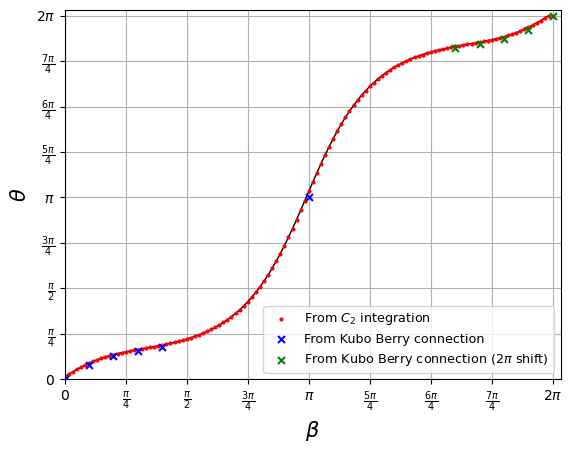

In [99]:
#### Plotting theta(beta)

fig, ax = plt.subplots()

### Riemann sum
ax.plot(betas, thetas_c2.real, lw=1, zorder=2, c='k')  
ax.scatter(betas, thetas_c2.real, s=4, zorder=2, c='r', label=r'From $C_2$ integration')
ax.scatter(betas_kc[:11], thetas_kc[:11], s=25, c='b', zorder=3, marker='x', label='From Kubo Berry connection')
ax.scatter(betas_kc[11:], thetas_kc[11:]+2*np.pi, s=25, c='green', zorder=3, marker='x', label=r'From Kubo Berry connection ($2\pi$ shift)')

ax.set_xlabel(r"$\beta$", size=15)
ax.set_ylabel(r"$\theta$", size=15)

tick_positions = np.arange(0, 2*np.pi+np.pi/4, np.pi/4)
tick_labels = [
    r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
    r"$\frac{5\pi}{4}$", r"$\frac{6\pi}{4}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]

# Set the ticks and labels for both axes
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

ax.set_ylim(0, 2*np.pi+0.1)
ax.set_xlim(0, 2*np.pi+0.1) 

# ax.set_ylim(np.pi-0.5, np.pi+0.5)
# ax.set_xlim(np.pi-0.1, np.pi+0.1) 

ax.grid()
ax.legend(loc='lower right', prop={'size': 9.2})
# ax.set_title(f"number of parameters: {n_param}")

In [86]:
main(np.pi, 50,50,50)

theta = 3.1415935148372296
theta - pi = 8.612474364788625e-07


(3.1415935148372296+3.3032671962875943e-10j)

In [54]:
nkxs = np.arange(25, 150, 25)
delta_theta_curv = np.zeros(nkxs.shape)
thetas_beta_pi_curv = np.zeros(nkxs.shape)
delta_theta_conn = np.zeros(nkxs.shape)
thetas_beta_pi_conn = np.zeros(nkxs.shape)

for idx, nkx in enumerate(nkxs):
    print(nkx)
    nks = nkx, nkx, nkx

    theta_curv = main(np.pi, *nks, curv=True)
    theta_conn = main(np.pi, *nks, curv=False)

    delta_theta_curv[idx] = abs(theta_curv.real) - np.pi
    thetas_beta_pi_curv[idx] = theta_curv.real

    delta_theta_conn[idx] = abs(theta_conn.real) - np.pi
    thetas_beta_pi_conn[idx] = theta_conn.real

25
theta = 3.139261013957857
theta - pi = -0.0023316396319361665
theta = 3.133550108334766
theta - pi = -0.008042545255027012
50
theta = 3.1415935148372296
theta - pi = 8.612474364788625e-07
theta = 3.141569925917167
theta - pi = -2.272767262612163e-05
75
theta = 3.141592655842559
theta - pi = 2.252765973764781e-09
theta = 3.1415925730761067
theta - pi = -8.051368638462009e-08
100
theta = 3.141592667663973
theta - pi = 1.4074180043621709e-08
theta = 3.1415934808487447
theta - pi = 8.272589515634365e-07
125
theta = 3.1415926766895947
theta - pi = 2.3099801627068928e-08
theta = 3.1415924749895034
theta - pi = -1.7860028966865116e-07


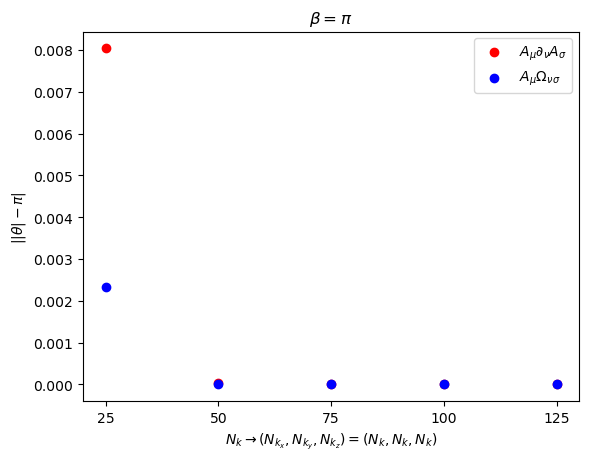

In [70]:
fig, ax = plt.subplots()

ax.scatter(nkxs[:], abs(delta_theta_conn[:]), c='r', label=r'$A_{\mu} \partial_{\nu} A_{\sigma}$')
ax.scatter(nkxs[:], abs(delta_theta_curv[:]), c='b', label=r'$A_{\mu}\Omega_{\nu\sigma}$')

ax.set_xlabel(r'$N_k \rightarrow (N_{k_x}, N_{k_y}, N_{k_z}) = (N_{k}, N_{k}, N_{k})$')
ax.set_ylabel(r'$| |\theta| - \pi |$')
ax.set_title(r"$\beta = \pi$")
ax.set_xticks(nkxs)

plt.legend()

In [31]:
nkx = 100
nks = nkx, nkx, nkx
main(np.pi, *nks, curv=True)

theta = 3.141592667663973
theta - pi = 1.4074180043621709e-08


In [27]:
%lprun -f main main()

theta = 3.1415934808487447
theta - pi = 8.272589515634365e-07


Timer unit: 1e-09 s

Total time: 11.7614 s
File: /var/folders/nn/m4t491h92ss8vwl56z761h6c0000gn/T/ipykernel_56072/1668646305.py
Function: main at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def main():
     2         1       1000.0   1000.0      0.0      beta = np.pi
     3         1          0.0      0.0      0.0      nks = 100, 100, 100
     4                                           
     5         1    2222000.0    2e+06      0.0      model = fu_kane_mele(t, soc, m, beta)
     6         1  248422000.0    2e+08      2.1      bloch_states = Bloch(model, *nks)
     7         1  545501000.0    5e+08      4.6      bloch_states.set_Bloch_ham()
     8                                           
     9                                               # Bloch Hamiltonian, reshape and get eigenvector shapes
    10         1          0.0      0.0      0.0      H_k = bloch_states.H_k
    11         1       2000.0   2000.0